In [1]:
!cat /proc/uptime | awk '{print $1 /60 " mins (" $1 "sec)"}'

21.256 mins (1275.36sec)


# Google Drive との接続

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
!ls

In [5]:
!ls millionlive_idol_predictor/

millionlive_idolname.json  script_data	tmp


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
%config inlineBackend.figure_format = 'retina'

# 学習

In [0]:
import sys, os.path, glob
import json
from collections import OrderedDict
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, ZeroPadding2D, MaxPooling2D, Reshape, Input, concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, Callback, CSVLogger, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

In [0]:
millionlive_dir = './millionlive_idol_predictor/'
script_dir = millionlive_dir + 'script_data/'
idol_meta_data_file = millionlive_dir + 'millionlive_idolname.json'
tmp_dir = millionlive_dir + 'tmp/'

In [0]:
# jsonの読み込み
def load_json(idol_meta_data_file=idol_meta_data_file):
    with open(idol_meta_data_file, 'r') as f:
        idol_meta_data = json.load(f, object_pairs_hook=OrderedDict) # jsonの順序を保持したままOrderdDictを生成
        #print(idol_meta_data['idols'])
        for idol in idol_meta_data['idols']:
            print('{0}\tid: {1}\tidol_name: {2}'.format(idol['idol_id'], idol['id'], idol['idol_name']))
    return idol_meta_data['idols']

In [0]:
# 各アイドルのセリフデータを読み込む
def load_script(idols):
    all_idol_script = np.empty((0,2))
    print('Loading idol script data...')
    for idol in idols:
        print('Loading {}.txt...'.format(idol['idol_id']))
        script_line = []
        with open('{}{}.txt'.format(script_dir, idol['idol_id']), "r") as f:
            for line in f:
                script_line.append(line.strip().replace('　',''))
        print('Finished loading.')
        
        np_idol_script = np.array([script_line]).T
        np_ids = np.array([np.zeros(len(np_idol_script)) + int(idol['id'])]).astype(np.int64).T
        idol_id_data = np.hstack((np_idol_script, np_ids))
        print('shape: {}'.format(np.shape(idol_id_data)))
        
        all_idol_script = np.vstack((all_idol_script, idol_id_data))
    print('All idol scripts has been integrated.')
    print('shape: {}'.format(np.shape(all_idol_script)))
    print(all_idol_script)
    
    return all_idol_script

In [0]:
# それぞれの行を整数のUnicodeポイントに変換する
def encode_text(txt, max_length=130):
    txt_list = []
    for line in txt:
        txt_line = [ord(x) for x in str(line).strip()]
        # Returning the encoded text in array, just like below
        # [25991, 31456, 12391, 12399, 12394, 12367, 12387, 12390, 23383, 24341, 12391, 12354, 12427, 12290]
        txt_line = txt_line[:max_length] # max_length文字(デフォルト)までで打ち切り
        txt_len = len(txt_line) # 文の長さ
        if txt_len < max_length: # 文がmax_length文字未満なら、残りをゼロ埋め
            txt_line += ([0] * (max_length - txt_len))
        txt_list.append((txt_line))
    return txt_list

In [0]:
def load_data():
    idols = []
    idols = load_json()
    all_idol_script = load_script(idols)

    # 訓練データ(入力)の作成
    encoded_script_list = encode_text(all_idol_script[:,0]) # テキスト列をUnicodeポイントにエンコードする
    script = np.array(encoded_script_list) # NumPy配列に変換

    # 訓練ラベル(教師データ)の作成
    id_list = all_idol_script[:,1] # id列を代入
    label = np_utils.to_categorical(id_list) # one-hot表現に変換

    return script, label

In [0]:
# Character-level Convolutional Neural Networkのモデルの定義
def create_model(embed_size=256, max_length=130, filter_sizes=(1, 2, 3, 4, 5), filter_num=512):
    inp = Input(shape=(max_length,))
    #print('inp: ' + str(np.shape(inp)))
    # Embedding層でUnicodeポイントの整数(=1文字)の1次元配列をベクトルの配列に変換する(ベクトルの配列だから、embed_size次元)
    # ハイパーパラメータ…input_dim=入力の各要素の最大インデックス+1=0xffff=65535=漢字のだいたいの最大値？, output_dim=入力の横幅(次元数)、初期化は一様分布
    emb = Embedding(0xffff, embed_size)(inp)
    #print('emb: ' + str(np.shape(emb)))
    # 畳み込み層が受け取る入力を生成する。Reshapeで軸のチャンネル数を追加
    # Conv層が受け取る入力のshape (batch_size,) + (高さ, 横幅, チャンネル)に変形
    emb_ex = Reshape((max_length, embed_size, 1))(emb)
    #print('emb_ex: ' + str(np.shape(emb_ex)))

    # 入力の横幅と、フィルタの横幅は一致する
    # 同一の入力に対して、1〜5の高さの複数のフィルタを1文字ずつスライドさせて畳み込む。その後、プーリング層に流す。
    # 1〜5文字ぶんの高さのフィルタを適用している。これは、1-gram〜5-gramを模倣している。
    conv_0 = Conv2D(filter_num, (filter_sizes[2], embed_size), activation='relu', input_shape=(max_length, embed_size, 1))(emb_ex)
    pad_0 = ZeroPadding2D((1,1))(conv_0)
    conv_0_1 = Conv2D(filter_num, (filter_sizes[2], 3), activation='relu', input_shape=(max_length, embed_size, 1))(pad_0)
    
    conv_1 = Conv2D(filter_num, (filter_sizes[3], embed_size), activation='relu', input_shape=(max_length, embed_size, 1))(emb_ex)
    pad_1 = ZeroPadding2D((1,1))(conv_0)
    conv_1_1 = Conv2D(filter_num, (filter_sizes[3], 3), activation='relu', input_shape=(max_length, embed_size, 1))(pad_1)
    
    conv_2 = Conv2D(filter_num, (filter_sizes[4], embed_size), activation='relu', input_shape=(max_length, embed_size, 1))(emb_ex)
    pad_2 = ZeroPadding2D((1,1))(conv_0)
    conv_2_1 = Conv2D(filter_num, (filter_sizes[4], 3), activation='relu', input_shape=(max_length, embed_size, 1))(pad_2)

    conv_3 = Conv2D(filter_num, (filter_sizes[0], embed_size), activation='relu', input_shape=(max_length, embed_size, 1))(emb_ex)
    conv_4 = Conv2D(filter_num, (filter_sizes[1], embed_size), activation='relu', input_shape=(max_length, embed_size, 1))(emb_ex)
    
    pool_0 = MaxPooling2D(pool_size=(max_length - filter_sizes[2] + 1, 1))(conv_0)
    pool_0_1 = MaxPooling2D(pool_size=(max_length - filter_sizes[2] + 1, 1))(conv_0_1)
    pool_1 = MaxPooling2D(pool_size=(max_length - filter_sizes[3] + 1, 1))(conv_1)
    pool_1_1 = MaxPooling2D(pool_size=(max_length - filter_sizes[3] + 0, 1))(conv_1_1)
    pool_2 = MaxPooling2D(pool_size=(max_length - filter_sizes[4] + 1, 1))(conv_2)
    pool_2_1 = MaxPooling2D(pool_size=(max_length - filter_sizes[4] + 0, 1))(conv_2_1)
    pool_3= MaxPooling2D(pool_size=(max_length - filter_sizes[0] - 3, 1))(conv_3)
    pool_4= MaxPooling2D(pool_size=(max_length - filter_sizes[1] - 2, 1))(conv_4)
    
    # 畳み込んだ結果を結合する。これは、複数のN-gramをまとめて利用していることと同じようになる。
    merged_convs = concatenate([pool_0, pool_0_1, pool_1, pool_1_1, pool_2, pool_2_1, pool_3, pool_4])
    # 結合した出力を平坦にReshapeして、全結合層に流す。
    #reshape = Reshape((filter_num * (len(filter_sizes)),))(merged_convs)
    reshape = Flatten()(merged_convs)
    fc1 = Dense(128, activation='relu')(reshape)
    bn1 = BatchNormalization()(fc1) 
    do1 = Dropout(0.3)(bn1) # 正則化(Dropout)
    fc2 = Dense(9, activation='softmax')(do1) # 出力層(全結合層)
    model = Model(inputs=inp, outputs=fc2)
    # モデルの可視化
    #plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model

In [0]:
def plot_history(history):
    # 精度の履歴をプロット
    display('Model Acc')
    plt.plot(history.history['acc'],".-",label="accuracy")
    plt.plot(history.history['val_acc'],".-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    display('Model Loss')
    plt.plot(history.history['loss'],".-",label="loss",)
    plt.plot(history.history['val_loss'],".-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [0]:
def train(inputs, targets, batch_size=100, epoch_count=15, max_length=130, model_filepath='model.h5', learning_rate=0.001):
    # 学習率を少しずつ下げる
    start = learning_rate
    stop = learning_rate * 0.01
    learning_rates = np.linspace(start, stop, epoch_count)

    model = create_model(max_length=max_length)
    # オプティマイザはAdam
    optimizer = Adam(lr=learning_rate)
    #optimizer = Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    model.summary()
    
    target = os.path.join(tmp_dir, 'weights.*.hdf5')
    files = [(f, os.path.getmtime(f)) for f in glob.glob(target)]
    if len(files) != 0:
        latest_saved_model = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(latest_saved_model[0])
    
    # Logging file for each epoch
    csv_logger_file = tmp_dir + 'clcnn_training.log'
    
    # Checkpoint model for each epoch
    checkpoint_filepath = tmp_dir + 'weights.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'

    model.fit(inputs, targets,
              epochs=epoch_count,
              batch_size=batch_size,
              verbose=1,
              validation_split=0.1,
              shuffle=True,
              callbacks=[
                  LearningRateScheduler(lambda epoch: learning_rates[epoch]),
                  CSVLogger(csv_logger_file),
                  ModelCheckpoint(
                      filepath=checkpoint_filepath,
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False,
                      monitor='val_loss')
              ])

    model.save(model_filepath)
    plot_history(model.history)

In [0]:
def start_train():
    Xs, Ys = load_data()
    train(Xs, Ys)

haruka	id: 0	idol_name: 天海春香
chihaya	id: 1	idol_name: 如月千早
yukiho	id: 2	idol_name: 萩原雪歩
karen	id: 3	idol_name: 篠宮可憐
emily	id: 4	idol_name: エミリー・スチュアート
shiho	id: 5	idol_name: 北沢志保
takane	id: 6	idol_name: 四条貴音
mizuki	id: 7	idol_name: 真壁瑞希
matsuri	id: 8	idol_name: 徳川まつり
Loading idol script data...
Loading haruka.txt...
Finished loading.
shape: (170, 2)
Loading chihaya.txt...
Finished loading.
shape: (169, 2)
Loading yukiho.txt...
Finished loading.
shape: (158, 2)
Loading karen.txt...
Finished loading.
shape: (178, 2)
Loading emily.txt...
Finished loading.
shape: (154, 2)
Loading shiho.txt...
Finished loading.
shape: (184, 2)
Loading takane.txt...
Finished loading.
shape: (167, 2)
Loading mizuki.txt...
Finished loading.
shape: (177, 2)
Loading matsuri.txt...
Finished loading.
shape: (178, 2)
All idol scripts has been integrated.
shape: (1535, 2)
[['トップアイドル目指して、歌も踊りも頑張ります！よろしくお願いします♪' '0']
 ['お仕事、頑張るぞー！なーんて、えへへ…。' '0']
 ['張り切っていっちゃいましょうっ！' '0']
 ...
 ['みんな、まつりのお城にようこそなのです！わんだほー！でびゅーてぃほー！なステ

'Model Acc'

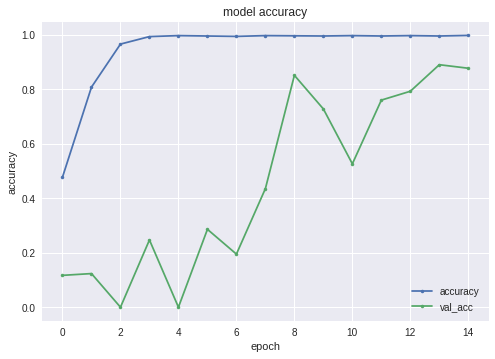

'Model Loss'

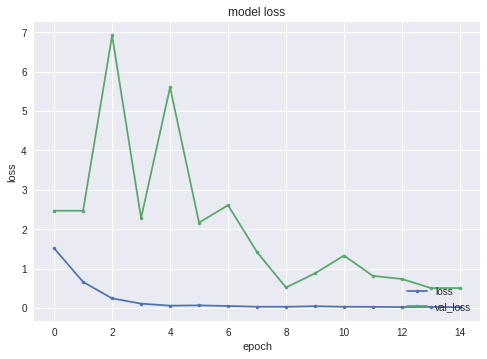

In [79]:
start_train()

# 推論

In [0]:
def encode_pred_text(raw_txt, max_length=130):
    txt = [ord(x) for x in str(raw_txt).strip().replace('　','')]
    txt = txt[:max_length]
    if len(txt) < max_length:
        txt += ([0] * (max_length - len(txt)))
    return txt

In [81]:
idols = load_json()
model = load_model('model.h5')

haruka	id: 0	idol_name: 天海春香
chihaya	id: 1	idol_name: 如月千早
yukiho	id: 2	idol_name: 萩原雪歩
karen	id: 3	idol_name: 篠宮可憐
emily	id: 4	idol_name: エミリー・スチュアート
shiho	id: 5	idol_name: 北沢志保
takane	id: 6	idol_name: 四条貴音
mizuki	id: 7	idol_name: 真壁瑞希
matsuri	id: 8	idol_name: 徳川まつり


In [82]:
_txt = encode_pred_text(input())
result = model.predict(np.array([_txt]))
predict_results = result[0,:]
sorted_results = sorted([(i,e) for i,e in enumerate(list(predict_results))], key=lambda x:x[1]*-1)
#print(sorted_results)
for result in sorted_results:
    id, prob = result
    if float(prob)*100 == 0: 
      prob += .01
    print('{}\t: {}%'.format(idols[id]['idol_name'], round(float(prob)*100, 2)))

ラテは…エスプレッソ…あの、どんな味なんですか？
北沢志保	: 80.4%
篠宮可憐	: 10.12%
如月千早	: 4.1%
徳川まつり	: 2.31%
エミリー・スチュアート	: 1.21%
天海春香	: 0.8%
萩原雪歩	: 0.61%
真壁瑞希	: 0.32%
四条貴音	: 0.12%
